# ERV differentiation

Two main research questions:
1. Are ERV's differentially expressed in SCC versus AC?
2. Are ERV's involved in immune surveillance in lung cancer

We have to 
* identify ERV's in Adeno and SCC
* identify granzy mand perforin expression per subtype
* identify IFN gene expression per subtype
* silencing of ERV by methylation in normal tissue



In [684]:
import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

import os
import sys
import re
from numba import jit
from collections import Counter
from collections import namedtuple

In [96]:
max_nans_perc = 0.1

In [97]:
os.chdir('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/')

In [98]:
dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta.set_index('SampleID', inplace=True)

In [99]:
erv_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if 'ERV' in _gene]
erv_genes += [_gene for _gene in dd['methylation'].Gene.unique() if 'ERV' in _gene]
erv_genes = list(set(erv_genes))

In [100]:
df_erv = {}
for _key in dd:  
    d = dd[_key]
    if 'Gene' in d.columns:
        temps = []
        for _gene in erv_genes:
            temps.append(d[d.Gene == _gene].to_pandas_df())            
        df_erv[_key] = pd.concat(temps, axis=0)
        
var_cols = {}

In [101]:
probe_map = df_erv['methylation'][['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']].reset_index().drop('index', axis=1)
df_erv['methylation'] = df_erv['methylation'].drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1)
df_erv['methylation'].set_index('probeID', inplace=True)
df_erv['methylation'] = df_erv['methylation'].transpose()

max_nans = int(max_nans_perc*df_erv['methylation'].shape[0])
df_erv['methylation'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['methylation'].index.tolist()]
df_erv['methylation'] = df_erv['methylation'].loc[:, df_erv['methylation'].columns[df_erv['methylation'].isna().sum()\
                                                                                   <max_nans].tolist()]
var_cols['methylation'] = df_erv['methylation'].columns.tolist()

In [102]:
exp_map = df_erv['RNAex'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']].reset_index().drop('index', axis=1)
df_erv['RNAex'] = df_erv['RNAex'].drop(['Chr', 'Start', 'Stop', 'Strand'], axis=1)
df_erv['RNAex'].set_index('Gene', inplace=True)
df_erv['RNAex'] = df_erv['RNAex'].transpose()

max_nans = int(max_nans_perc*df_erv['RNAex'].shape[0])
df_erv['RNAex'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['RNAex'].index.tolist()]
df_erv['RNAex'] = df_erv['RNAex'].loc[:, df_erv['RNAex'].columns[df_erv['RNAex'].isna().sum()\
                                                                                   <max_nans].tolist()]
var_cols['RNAex'] = df_erv['RNAex'].columns.tolist()

In [103]:
df_erv['mutation'] = df_erv['mutation'][df_erv['mutation'].Effect!='upstream_gene_variant']
mut_map = df_erv['mutation'][['Amino_Acid_Change', 'Gene', 'Chr', 'Start', 'Stop', 'Ref', 'Alt']].reset_index().drop('index', axis=1)
df_erv['mutation'] = df_erv['mutation'].drop(['Gene', 'Chr', 'Start', 'Stop', 'Ref', 'Alt'], axis=1)
df_erv['mutation'] = df_erv['mutation'].reset_index().drop('index', axis=1)
df_erv['mutation'] = df_erv['mutation'].rename(index=str, columns={'Sample_ID': 'SampleID'})
df_erv['mutation'].set_index('SampleID', inplace=True)
var_cols['mutation'] = df_erv['mutation'].columns.tolist()

In [104]:
cnv_map = df_erv['CNV'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']]
df_erv['CNV'] = df_erv['CNV'].drop(['Chr', 'Start', 'Stop', 'Strand'], axis=1)
df_erv['CNV'] = df_erv['CNV'].set_index('Gene').reset_index()
df_erv['CNV'] = df_erv['CNV'].transpose()
var_cols['CNV'] = df_erv['CNV'].columns.tolist()

In [105]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 'Overall Survival Status', 'Reponse To Therapy',
                                  'Pack Years', 'Smoking Status']
for _key in df_erv:
    df_erv[_key] = df_erv[_key].join(meta[meta_cols])

In [106]:
df_erv.keys()

dict_keys(['RNAex', 'mutation', 'methylation', 'CNV'])

## Check class/survival differentiation per feature

In [319]:
"""
     Information change: 
        * Kullback-Leibler divergence (have to make same number of bins)
        * cross-entropy
        * Shannon entropy change
"""
@jit
def _information_change(v1, v2, ent_type = 'kl', bin_type='fixed', num_bins=25):
    '''
    v1: vector one
    v2: vector two
    ent_type : kl, shannon, cross
    bin_type : auto, fixed
    num_bins : non-zero positive integer
    
    return entropy difference
    '''
    # get bins
    num_bins = num_bins if bin_type=='fixed' else bin_type
    v1bins = np.histogram(v1, density=True, bins=num_bins)
    v2bins = np.histogram(v2, density=True, bins=num_bins)
    
    ent1 = -np.sum(v1bins[0]*np.log2(v1bins[0]))
    ent2 = -np.sum(v2bins[0]*np.log2(v2bins[0]))    
    
    log2v1 = np.log2(v1bins[0])
    log2v2 = np.log2(v2bins[0])
    
    if ent_type == 'shannon':
        return 2*np.abs(ent1-ent2)/(np.abs(ent1)+np.abs(ent2))
    elif ent_type == 'cross':
        cross1 = -np.sum(v1bins[0]*log2v2)
        cross2 = -np.sum(v2bins[0]*log2v1)        
        return 2*np.max([np.abs(cross1),np.abs(cross2)])/(np.abs(ent1)+np.abs(ent2))
    elif ent_type == 'kl':
        return 2*np.max([np.abs(np.sum(v1bins[0]*(log2v1-log2v2))),
                         np.abs(np.sum(v2bins[0]*(log2v2-log2v1)))])/(np.abs(ent1)+np.abs(ent2))

In [911]:
@jit
def _skewness(x, logscale=False, bound=False, scale=1000, sample=False, bias=True):
    '''
    x : array(N,1)
    return skewness
    '''
    std = np.std(x)
    mu = np.mean(x)
    N = x.shape[0]
    val = np.sum(np.power(x-mu, 3))/np.power(std, 3)
    if sample==False:
        if bound==False:
            if logscale==False:
                return val
            else:
                return np.log10(np.abs(val))*np.sign(val)
        else:
            return np.tanh(val/scale)
    else:
        return stats.skew(x, bias=bias)

@jit
def _kurtosis(x, logscale=False, sample=False, bias=True):            
    std = np.std(x)
    mu = np.mean(x) 
    val = np.sum(np.power(x-mu, 4))/np.power(std, 4)
    if sample==False:
        if logscale==False:
            return val
        else:
            return np.log10(np.abs(val))*np.sign(val)
    else:
        return stats.kurtosis(x, bias=bias, nan_policy='omit')

@jit
def _stanmom(x, mom=3, logscale=False, mutype=0):
    # mom : 3 is skewness, 4 is kurtosis
    std = np.std(x)
    if mutype==0:
        mu = np.mean(x)
    else:
        mu = np.median(x)
    val = np.sum(np.power(x-mu, mom))/np.power(std, mom)
    if logscale==False:
        return val
    else:
        return np.log10(np.abs(val))*np.sign(val)
    
from unidip import UniDip  
import unidip.dip as dip
def _multimodality(x, method='hartigan'):
    x = np.msort(x)
    # multi-modality can be extracted from the number of inflection points on a q-q plot 
    if method=='hartigan':
        return len(UniDip(x).run())
    
def _qq(x, cdist='norm', minkowski=2):
    # surface area,max_slope,min_slope
    res = stats.probplot(x, dist=stats.norm, plot=None, fit=False)
    dist_cos = sc.spatial.distance.cosine(res[0], res[1])
    dist_euc = sc.spatial.distance.minkowski(res[0], res[1], p=minkowski)
    return dist_cos*dist_euc
 
def _qq2(x1, x2):
    # surface area,max_slope,min_slope
    perc1 = np.percentile(val_series[0], q=np.arange(0, 10,1))
    perc2 = np.percentile(val_series[1], q=np.arange(0, 10,1))
    plt.plot(perc1, perc2)
    minv = np.min([np.min(perc1), np.min(perc2)])
    maxv = np.max([np.max(perc1), np.max(perc2)])
    plt.title('Q-Q')  
    plt.xlabel('q-'+meta_vals[0])
    plt.ylabel('q-'+meta_vals[1])

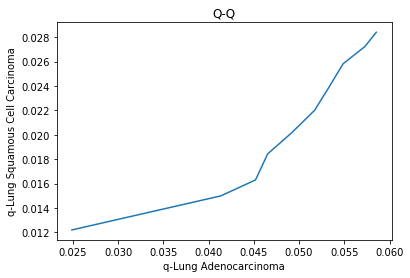

In [912]:
_qq2(val_series[0], val_series[1])

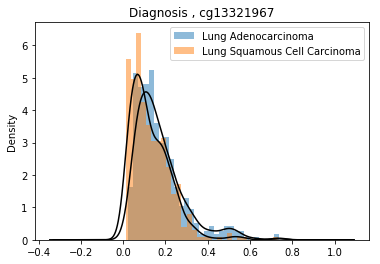

In [896]:
i=43
meta_col = 'Diagnosis' # 
meta_vals = df_erv['methylation'][meta_col].unique().tolist()
val_series = []
for _meta_col_val in meta_vals:
    if pd.isna(_meta_col_val)==False:
        x = df_erv['methylation'].loc[df_erv['methylation'][meta_col]==_meta_col_val, var_cols['methylation'][i]]
        x.plot.hist(bins=30, alpha=0.5, density=True, label=_meta_col_val)
        x.plot.kde(color='black', label='')
        val_series.append(x)
plt.title(meta_col+' , '+var_cols['methylation'][i])
plt.legend()

In [875]:
@jit
def _cdf(x,bin_size=5):
    x = np.sort(x)
    c = len(x)
    res, _res= np.empty((0, 2)), np.empty((0,2))
    for i in range(bin_size, c):
        if i%bin_size==0:
            _res = np.array([i/c, np.median(x[(i-bin_size):i])])
            res = np.append(res, [_res], axis=0)    
    return res
# np.asarray([[i/c, np.median(x[(i-bin_size):i])] for i in range(bin_size, c) if i%bin_size==0])

@jit
def _cdfcoeff(x, bin_size=5):
    # better to take out the creation of the cdf and split the function (_cdf, _cdfcoeff)
    lt = _cdf(x, bin_size=bin_size)
    xmm = x.max()-x.min()
    diff1 = np.diff(lt[:,1])*lt[:-1, 0]
    diff1[0:1] = 0  
    diff2 = np.diff(diff1)
    diff2[0:1] = 0 
    diff2 = diff2*lt[:-2, 0]

    # modus is peak in f'' followed by valley  in f''
    xmmp = xmm**4
    tv, td = (diff2[0:-1]-diff2[1:]), (np.sign(diff2[0:-1])-np.sign(diff2[1:]))
    xrelcount, xbumpmean, xdiffmean, xdiffvar = (td>0).sum()/(lt.shape[0]-1), tv[tv>0].mean()/xmmp, diff1.mean()/xmmp, diff1.std()/xmmp
    
    return xrelcount, xbumpmean, xdiffmean, xdiffvar

@jit
def _cdf2(x1, x2, bin_size=5, minkowsi=1):
    '''
     takes the Minkowski distance between the ecdf's and the Russell-Rao distance of the bump indicators
    ''' 
    x1 = np.sort(x1)
    c = len(x1)
    lt1 = _cdf(x1, bin_size=bin_size)

    x2 = np.sort(x2)
    c = len(x2)
    lt2 = _cdf(x2, bin_size=bin_size)

    l1 = minterp(lt1[:,0], lt1[:,1], axis=0, extrapolate=True)(lt1[:,0])
    l2 = minterp(lt2[:,0], lt2[:,1], axis=0, extrapolate=True)(lt1[:,0])

    l1diff = np.diff(l1)
    l2diff = np.diff(l2)

    l1diff2 = np.diff(l1diff)
    l2diff2 = np.diff(l2diff)

    l1diff2sign = np.sign(l1diff2)
    l2diff2sign = np.sign(l2diff2)

    l1bump = l1diff2sign[0:-1]-l1diff2sign[1:]
    l2bump = l2diff2sign[0:-1]-l2diff2sign[1:] 

    d1 = sc.spatial.distance.minkowski(l1, l2, p=minkowsi)*sc.spatial.distance.russellrao(l1bump, l2bump)
    d2 = sc.spatial.distance.minkowski(l1diff, l2diff, p=minkowsi)*sc.spatial.distance.russellrao(l1bump, l2bump)
    d3 = sc.spatial.distance.russellrao(l1bump, l2bump)   
    return d1,d2,d3

In [ ]:
'''
Univariated intra-distribution characterisations:
    * skewness
    * kurtosis
    * multimodality
    * normality test
        * Shapiro-Wilk
        * Anderson-Darling
        * Crámer-von-Mises criterion
        * Jarque-Bera
        * Gel-Gastwirth test
        * Bonett-Seier test
'''



In [ ]:
'''
Univariate inter-distribution distance:
        * Delta skewness
        * Delta kurtosis
        * Delta Normality test  (Shapiro-Wilk, Anderson-Darling)      
        * Kolmogorov-Smirnov (also normality test)
        * Cramér–von Mises criterion
        * Pearson's chi-squared test (only if all vars are binned and categorised)
        * Kuiper's test
        * Mann-Whitney U
        * Kruskall Wallis
        * nth-Wasserstein
        * FDR-BH-ANOVA
        * total variation distance
        * Hellinger distance
        * Bhattacharyya distance
'''



In [ ]:
'''
    similarity to dissimilarity:
    * d = 1 - s
    * d = sqrt(s(x,x)+s(y,y)-2s(x,y))
    * d= -log(s(x,y))
'''

'''
    dissimilarity to similarity:
    * s = exp(-d(x,y)/sigma)
    * s = 1/(1+d(x,y))
    * s = 1/2*(d^2(x,c) + d^2(y,c)-d^2(x,y))
    
'''

In [ ]:
'''
Pairwise distance:
    * Manhattan distance (only if all vars are binned and categorised)
    * Euclidean distance
    * Pearson  distance 
    * Kendall distance 
    * Spearman distance
    * 1-Cosine distance (pseudometric)
    * Mahalanobis distance
'''

In [ ]:
# get feature-feature similarity



# get sample-sample similarity



## make N s-s-s bins 


In [ ]:
# what combination of dimensions makes samples from different target groups most dissimilar?

## Check class/survival differentiation per feature combination 

## Check differentiation class/survival with/without ERV mutations